In [1]:
import sys, os, glob, scipy, sqlite3, json, matplotlib, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def ttest_1samp(dat, popmean = .5, verbose = True):
    if verbose:
        print('SD: ',np.std(dat))
        print('Stats:')
    stats = scipy.stats.ttest_1samp(dat, popmean = popmean)
    if verbose:
        print(stats)
        print('Cohen d:')
    coh_d = (np.mean(dat) - popmean)/np.std(dat)
    if verbose:
        print(coh_d)
    return(stats, coh_d)

def ttest_2samp(dat1, dat2):
    print('SD dat 1: ',np.std(dat1))
    print('SD dat 2: ',np.std(dat2))
    print('Stats:')
    stats = scipy.stats.ttest_ind(dat1, dat2)
    print(stats)
    print('Cohen d:')
    nx = len(dat1)
    ny = len(dat2)
    dof = nx + ny - 2
    coh_d = ((np.mean(dat1) - np.mean(dat2)) /
             np.sqrt(((nx-1)*np.std(dat1, ddof=1) ** 2 + (ny-1)*np.std(dat2, ddof=1) ** 2) / dof))
    print(coh_d)
    return(stats, coh_d)

### Load data

In [3]:
a = !pwd
baseDir = '/'.join(a[0].split('/')[0:-2])
print(baseDir)

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study4_InspectionGame


In [4]:
WS_dat = pd.read_csv(baseDir + '/Data/Cleaned/WS_dat.csv',index_col = 0)
quiz_dat = pd.read_csv(baseDir + '/Data/Cleaned/quiz_dat.csv',index_col = 0)
SPG_dat = pd.read_csv(baseDir + '/Data/Cleaned/SPG_dat.csv',index_col = 0)

In [5]:
WS_cond_dat = WS_dat.groupby(['subID','player_type'],as_index=False).mean()

In [6]:
subIDs = WS_dat['subID'].unique()

In [7]:
SPG_scores = SPG_dat.groupby(['subID','player_type'],as_index=False
                            ).mean()[['subID','player_type','score']]
SPG_scores_wide = SPG_scores.pivot(index = 'subID', columns = 'player_type', values = 'score').reset_index()
SPG_scores_wide['diff'] = SPG_scores_wide['opt'] - SPG_scores_wide['pess']
SPG_scores_wide['mean'] = (SPG_scores_wide['opt'] + SPG_scores_wide['pess'])/2
SPG_scores_wide.head()

player_type,subID,opt,pess,diff,mean
0,2001,0.9375,0.5000,0.4375,0.71875
1,2002,0.7500,0.4375,0.3125,0.59375
2,2003,0.9375,0.9375,0.0000,0.93750
3,2004,0.8750,0.6250,0.2500,0.75000
4,2005,0.6250,0.8125,-0.1875,0.71875


##### Quantify work/shirk effect

In [8]:
IPs = WS_dat.query('trial >9').groupby(['subID','player_type'],as_index=False).mean()[['subID','player_type','cost']]
IPs_wide = IPs.pivot(index = 'subID', columns = 'player_type', values = 'cost').reset_index()
IPs_wide['diff'] = IPs_wide['opt'] - IPs_wide['pess']
IPs_wide.head()

player_type,subID,opt,pess,diff
0,2001,10.8,11.2,-0.4
1,2002,19.4,19.6,-0.2
2,2003,30.0,1.6,28.4
3,2004,6.2,6.2,0.0
4,2005,11.6,10.8,0.8


##### Merge across tasks

In [11]:
SPG_pess_order = SPG_dat[['subID','block','player_type']].drop_duplicates().pivot(index='subID',columns = 'player_type', values='block').reset_index()[['subID','pess']]
SPG_pess_order.columns = ['subID','pess_order']

In [20]:
task_dat = SPG_scores_wide.merge(IPs_wide, on = 'subID', suffixes = ['_SPG','_WS']).merge(SPG_pess_order, on='subID')

## Relationship between SPG self-report and IG earnings

In [15]:
# Median split on IG distinguishing between WTP for Opt and Pess:
WTP_Q1 = task_dat['diff_WS'].describe()['25%']
WTP_D1 = task_dat['diff_WS'].describe(percentiles = [.1,.9])['10%']
WTP_Q3 = task_dat['diff_WS'].describe()['75%']
WTP_D9 = task_dat['diff_WS'].describe(percentiles = [.1,.9])['90%']
WTP_median = task_dat['diff_WS'].median()

In [16]:
subs_good_IG = task_dat.query('diff_WS > @WTP_D9')['subID'].tolist()
len(subs_good_IG)

16

In [17]:
subs_bad_IG = task_dat.query('diff_WS < @WTP_D1')['subID'].tolist()
len(subs_bad_IG)

16

In [21]:
!pip install wordcloud

     |████████████████████████████████| 225kB 4.3MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl size=158972 sha256=1cdbeac7d3fa1744fac203b9f5911f576d0d9a077c0745f0028151a01aff60f2
  Stored in directory: /Users/jeroen/Library/Caches/pip/wheels/bf/18/33/c6d0e1bb532e0587da731a02d990e62c483c8e49741e0c4bf3
Successfully built wordcloud


In [22]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS# Generate word cloud

In [23]:
self_report_text = SPG_dat[['subID','player_type','self-report']].drop_duplicates()
self_report_text.head()

,subID,player_type,self-report
0,2001,pess,I don't think F.A. had a strategy. They made b...
16,2001,opt,To maximize their earnings.
0,2002,opt,The highest payout
16,2002,pess,Most payoff
0,2003,opt,pick the option that has the higher possible r...


In [24]:
all_text = pd.DataFrame()
for performance in ['good','bad']:
    if performance == 'good':
        perf_list = subs_good_IG
    else:
        perf_list = subs_bad_IG
        
    for player in ['opt','pess']:
        perf_text = self_report_text.loc[self_report_text['subID'].isin(perf_list),:]
        
        play_text = perf_text.query('player_type == @player')['self-report'].values.tolist()
        play_text = ' '.join(play_text).lower()
        
        tmp = pd.DataFrame([[performance,player,play_text]],columns = ['performance','player','text'])
        all_text = all_text.append(tmp).reset_index(drop=True)

##### Plot

In [25]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(10, 5))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [26]:
def red_hi_color_func(word, font_size, position, orientation, random_state=1,
                    **kwargs):
    return "hsl(5, 80%, 50%)"
def blue_hi_color_func(word, font_size, position, orientation, random_state=1,
                    **kwargs):
    return "hsl(220, 80%, 50%)"
def red_lo_color_func(word, font_size, position, orientation, random_state=1,
                    **kwargs):
    return "hsl(5, 40%, 70%)"
def blue_lo_color_func(word, font_size, position, orientation, random_state=1,
                    **kwargs):
    return "hsl(220, 40%, 70%)"

In [27]:
col_dict = {'good':{'opt':red_hi_color_func,'pess':blue_hi_color_func},
            'bad':{'opt':red_lo_color_func,'pess':blue_lo_color_func}}
player_names = {'opt':'Greedy','pess':'Risk-Averse'}


In [28]:
all_clouds = pd.DataFrame()
for perfi,performance in enumerate(['good','bad']):
    for playi,player in enumerate(['opt','pess']):
        text = all_text.query('performance == @performance and player == @player')['text'].values[0]
        print(performance,player,text[:100])
        tmp = WordCloud(width = 1500, height = 1000, random_state=6,
                      background_color='white', colormap='RdBu', max_words = 20,
                      collocations=False, stopwords = STOPWORDS)
        tmp = tmp.generate(text)
        tmp = pd.DataFrame([[performance,player,tmp]],columns = ['performance','player','cloud'])
        all_clouds = all_clouds.append(tmp).reset_index(drop=True)

good opt pick the option that has the higher possible return to try to make the most money possible. score as
good pess to make sure the the lowest value possible to win was greater than the lowest possible of the other 
bad opt always make as much as possible they wanted to maximize their earnings while also decreasing the ris
bad pess there was none, it looked like random choices to me. they wanted to get the most money and were will


good opt
good pess
bad opt
bad pess


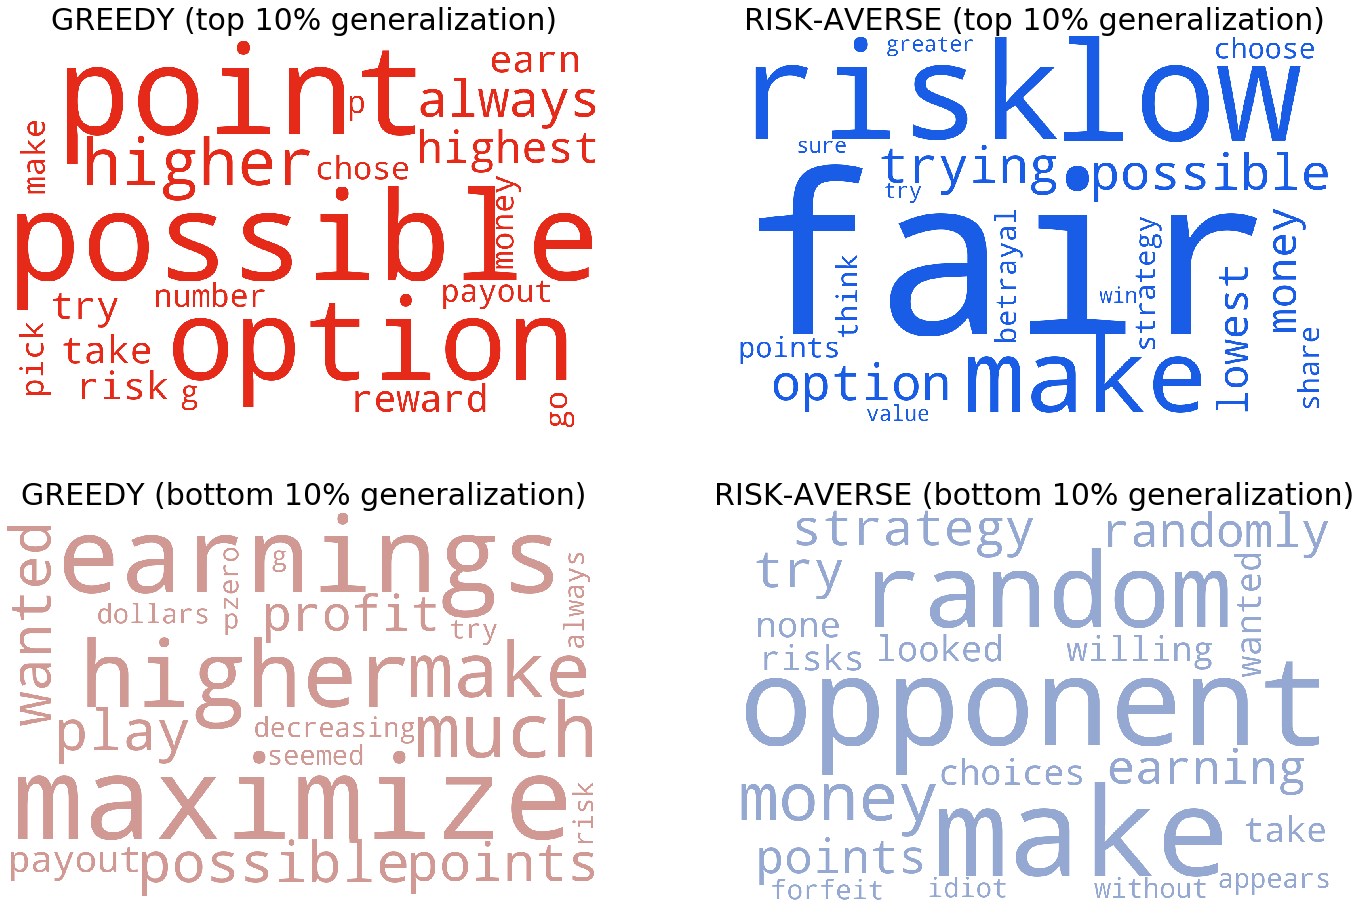

In [29]:
fig,ax = plt.subplots(2,2,figsize=[24,16])
# colfunx = [red_color_func,blue_color_func]
perf_group_indicator = ['top 10%','bottom 10%']
for perfi,performance in enumerate(['good','bad']):
    for playi,player in enumerate(['opt','pess']):
        print(performance,player)
        cloud = all_clouds.query('performance == @performance and player == @player')['cloud'].values[0]
        axcur = ax[perfi,playi]
#         axcur.imshow(cloud)
        axcur.imshow(cloud.recolor(color_func=col_dict[performance][player]))
        axcur.axis('off')
#         axcur.set(title = '%simist (%s participants)'%(player,performance))
        axcur.set_title(player_names[player].upper() + ' (%s generalization)'%perf_group_indicator[perfi],
                        fontdict = {'size':30})